In [1]:
cd ..

/home/arjun/Desktop/Arjun/School/cs294-stable-color


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

from src.gauss_color import EMGauss
from utils.image_gen import ImageGenerator
from utils.hex_lattice import gen_hex_lattice, gen_color_lattice
#from sparse_coder.prep_field_dataset import get_data_matrix

In [4]:
plt.rcParams.update({'font.size': 7})

In [5]:
FONTSIZE=7

In [6]:
from src.gauss_plots import plot_image, plot_rfs, compare_fourier, plot_path_estimate, get_snr_list

In [7]:
l_i = 20
ds = 0.3
de = 1.09
rf_ratio = 0.203
# rf_ratio = 0.4
n_t = 5
l_n = (l_i * ds / np.sqrt(2))

In [114]:
#mat = get_data_matrix(path='data/IMAGES.npy', l_patch=l_i, n_patches=10)
#s_gen = mat[3].astype('float32')
I = ImageGenerator(l_i)
I.make_big_e()
s_gen = I.img.astype('float32')

# invert colors for additive color
#s_gen[s_gen == 1] = 0.5
#s_gen[s_gen == 0] = 1
#s_gen[s_gen == 0.5] = 0

# subtractive color - color range 0,255 mapped to 0,1
# works like a printer - subtract
rgb = [0.0, 255.0, 255.0]
s_gen_color = np.dstack((s_gen,s_gen,s_gen))
s_gen_color[:,:,0] = s_gen_color[:,:,0] - (rgb[0]/255.0) # R
s_gen_color[:,:,1] = s_gen_color[:,:,1] - (rgb[1]/255.0) # G
s_gen_color[:,:,2] = s_gen_color[:,:,2] - (rgb[2]/255.0) # B
s_gen_color[s_gen_color < 0] = 0

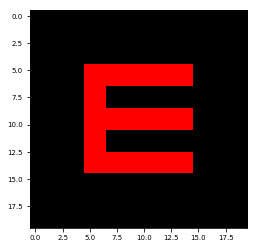

In [115]:
XE, YE = gen_color_lattice(0.4, 0.4, 0.2, 8.00, 0.8)

# shift mosaic to fit in plot
scaleR = [9.5]*len(XE[0])
scaleG = [9.5]*len(XE[1])
scaleB = [9.5]*len(XE[2])

# plot mosaic
#plt.scatter(XE[0]+scaleR, YE[0]+scaleR, color='red', alpha=0.5)
#plt.scatter(XE[1]+scaleG, YE[1]+scaleG, color='green', alpha=0.5)
#plt.scatter(XE[2]+scaleB, YE[2]+scaleB, color='blue', alpha=0.5)

# plot colored E
plt.imshow(s_gen_color)
#plt.axes().set_aspect('equal')

s_gen = s_gen.reshape(l_i*l_i,)

In [128]:
#s_gen_color.shape
#s_gen = s_gen_color[:,:,0] #1st run
#s_gen = s_gen_color[:,:,1] #2nd run
#s_gen = s_gen_color[:,:,2] #3rd run
s_gen = s_gen.reshape(l_i*l_i,)
#plt.imshow(s_gen.reshape(l_i, l_i))

In [129]:
emg = EMGauss(
    test='blue', # redgreen for runs 1st,2nd; blue for 3rd
    l_i=l_i, 
    motion_gen={'mode': 'Diffusion', 'dc': 4.},
    motion_prior={'dc': 10.},
    n_t=n_t,
    ds=ds,
    de=de,
    n_p=50,
    print_mode=True,
    l_n=l_n,
    rf_ratio=rf_ratio,
    sig_obs=0.1,
    r=0.47,
    g=0.47,
    b=0.6,
    neuron_layout='hex_color'
)

In [130]:
n_repeats = 2

In [131]:
%%time
data_ = []
for _ in range(n_repeats):
    m, xr, yr = emg.gen_data(s_gen)
    s, s_est_ = emg.run_em(m, n_passes=1, n_itr=n_t, reg=1.)
    emg.pf.calculate_means_sdevs()

    means = emg.pf.means.copy()
    sdevs = emg.pf.sdevs.copy()

    
    data_.append(
        {
            'm': m,
            'xr': xr,
            'yr': yr,
            's': s,
            's_est_': s_est_,
            'means': means,
            'sdevs': sdevs
        })

CPU times: user 2.68 s, sys: 1.67 s, total: 4.35 s
Wall time: 1.32 s


In [132]:
with emg.tb.sess.as_default():
    xe, ye = emg.tb.sess.run([emg.tb.t_xe, emg.tb.t_ye])
    xs, ys = emg.tb.sess.run([emg.tb.t_xs, emg.tb.t_ys])


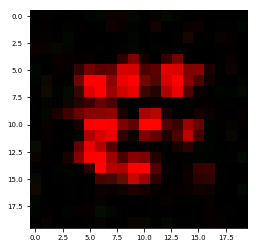

In [133]:
#plt.scatter(xr,yr)
#plt.scatter(xs,ys, color='blue', alpha=0.2)
#plt.scatter(xe,ye, color='red', alpha=0.2)

# 1st run
#stotal = [[],[],[]]
#stotal[0] = s
# 2nd run
#stotal[1] = s 
# 3rd run
stotal[2] = s
scolor = np.dstack((stotal[0].reshape(l_i,l_i), stotal[1].reshape(l_i,l_i),stotal[2].reshape(l_i,l_i)))
plt.imshow(scolor)

In [15]:
for d in data_:
    d['snr_list'] = get_snr_list(s_gen, d['s_est_'], (d['xr'], d['yr']), d['means'], xs, ys, ds)

In [16]:
from src.gauss_plots import smooth_image

def plot_image(fig, ax, s, ds, colorbar=False, alpha=1.,
                    cmap=plt.cm.gray, title='', vmin=None, vmax=None):
    """
    Plot the image.

    Parameters
    ----------
    fig : plt.Figure
        Figure
    ax : plt.Axes
        Axes to plot image
    s : array, shape (l_i, l_i)
        Unraveled image to be plotted.
    ds : float
        Spacing between pixels.
    colorbar : bool
        If true, show a colorbar.
    alpha : float
        Alpha for showing image.
    cmap : plt.cm
        Colormap.
    title : str
        String for the title.
    vmin, vmax : float
        Min and max for imshow.
    """
    s1 = smooth_image(s)
    l_i = s.shape[0]
    if vmin is None:
        vmin = s.min()
    if vmax is None:
        vmax = s.max()
    a = ds * l_i / 2
    im = ax.imshow(
        s1, cmap=cmap, interpolation='gaussian',
        extent=[-a, a, -a, a], alpha=alpha,
        vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=FONTSIZE)
    if colorbar:
        fig.colorbar(im, ax=ax)



def plot_fourier_spectrum(fig, ax, s, ds, de):
    """
    Plot the fourier spectrum.

    Parameters
    ----------
    fig : plt.Figure
        Figure for plotting
    ax : plt.axes
        Plotting axes.
    s : array, shape (l_i, l_i)
        Image to get the fourier transform of.
    ds : float
        Spacing of the pixels.
    de : float
        Spacing of Receptive fields.
    """
    s1 = smooth_image(s)
    l_i = s.shape[0]
    ax.set_title('Fourier Transform', fontsize=FONTSIZE)
    freqs = np.fft.fftshift(np.fft.fftfreq(l_i)) / ds
    df = (freqs[1] - freqs[0])
    fmin = freqs[0] - df / 2
    fmax = freqs[-1] + df / 2
    im = ax.imshow(np.abs(np.fft.fftshift(np.fft.fft2(s1))),
               extent=[fmin, fmax, fmin, fmax],
               cmap=plt.get_cmap('afmhot'))
    fn = 0.5 * de
    ax.add_patch(plt.Circle((0, 0), fn, color='gray', alpha=0.5))
    ax.add_patch(plt.Circle((0, 0), fn / (np.sqrt(3.) / 2.), color='gray', alpha=0.25))
    fig.colorbar(im, ax=ax)



def compare_fourier(s_gen, s_inf, snr_list, l_i, ds, de, 
             xe, ye, rf_ratio):
    """ 
    Plot the two fourier spectrums.

    Parameters
    ----------
    s_gen : array, shape (l_i, l_i)
      Image that generated the observations.
    s_inf : array, shape (l_i, l_i)
      Inferred image.
    ds : float
      Spacing between pixels.
    de : float
      Spacing between receptors.
    xe, ye : array, shape (n_sensors,)
      X, Y positions of sensors.
    """
    n_row, n_col = 2, 3
    fig, axes = plt.subplots(nrows=n_row, ncols=n_col, 
                        figsize=(n_col * 7/3., n_row * 2))
    vmin, vmax = s_gen.min(), s_gen.max()

    for i, (s, name) in enumerate(zip([s_gen, s_inf], ['Original', 'Estimate'])):
        ax = axes[i][0]
        plot_image(fig, ax, s, ds=ds, title='Image: {}'.format(name),
                 vmin=vmin, vmax=vmax)

        ax = axes[i][1]
        plot_fourier_spectrum(fig, ax, s, ds, de) 

    ax = axes[0][2]
    plot_rfs(ax, xe, ye, de, rf_ratio, alpha=0.5)
    plot_image(
      fig, ax, s_gen, ds=ds,
      title='Image: {}'.format('Image with RFs')
    )

    ax = axes[1][2]
#     ax.plot(snr_list)
    ax.set_title('SNR as a function of time', fontsize=FONTSIZE)
    return fig, axes

In [17]:
from src.analyzer import plot_fill_between

In [18]:
snrs = np.array([d['snr_list'] for d in data_])

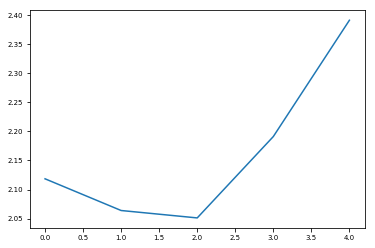

In [19]:
plt.plot(snrs.T);

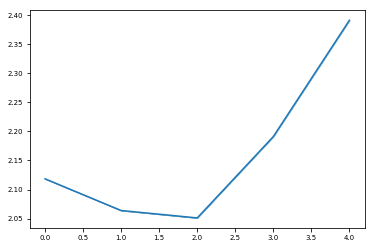

In [20]:
ax = plt.axes()
plot_fill_between(ax, np.arange(snrs.shape[1]), snrs)

In [21]:
data_[0].keys()

['s_est_', 'snr_list', 'means', 'm', 's', 'sdevs', 'xr', 'yr']

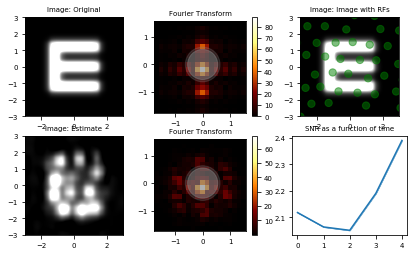

In [22]:
fig, axes = compare_fourier(
    s_gen.reshape(l_i, l_i), 
    data_[0]['s_est_'][-1].reshape(l_i, l_i), 
    data_[0]['snr_list'], 
    l_i, ds, de, xe, ye, rf_ratio)
ax = axes[1][2]
plot_fill_between(ax, np.arange(snrs.shape[1]), snrs)
plt.savefig('gauss_super_res.pdf')

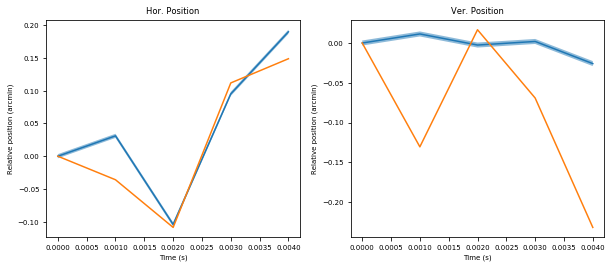

In [23]:
plt.figure(figsize=(10, 4))
for d in range(2):
    plt.subplot(1, 2, d + 1)
    plot_path_estimate(data_[0]['means'], data_[0]['sdevs'], (xr, yr), d=d, q=100)

In [24]:
#plt.imshow(s_gen.reshape(l_i, l_i))
#plt.colorbar()